In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
appliences_data = pd.read_csv("ECUK_2024_Electrical_Products_tables - Table A1.csv", header=4)

In [4]:
appliences_data = appliences_data.iloc[1:].reset_index(drop=True)
appliences_data = appliences_data.dropna(axis=1, how='all')
appliences_data = appliences_data.rename(columns={appliences_data.columns[0]: "Year"})
appliences_data["Year"] = pd.to_numeric(appliences_data["Year"], errors="coerce")
appliences_data = appliences_data[(appliences_data["Year"] >= 1970) & (appliences_data["Year"] <= 2019)]

In [5]:
columns = [
    'Year',
    'TOTAL LIGHTING',
    'COLD - Total',
    'WET - Total',
    'TOTAL TV',
    'CONSUMER ELECTRONICS - Total',
    'COMPUTERS - Total',
    'COOKING - Total',
    'OTHER - TOTAL'
]

In [6]:
appliences_data.columns = appliences_data.columns.map(lambda x: str(x).strip())

In [7]:
valid_cols = [col for col in columns if col in appliences_data.columns]
filtered_appliences_data = appliences_data[valid_cols].copy()

In [8]:
for col in filtered_appliences_data.columns:
    if col != 'Year':
        filtered_appliences_data[col] = pd.to_numeric(filtered_appliences_data[col].astype(str).str.replace(',', ''), errors='coerce')

In [9]:
print(filtered_appliences_data.tail())

      Year  TOTAL LIGHTING  COLD - Total  WET - Total  TOTAL TV  \
45  2015.0           11935       12725.0      14355.0    2061.0   
46  2016.0           11554       12046.0      14301.0    1899.0   
47  2017.0           11107       11919.0      14260.0    1732.0   
48  2018.0           10817       11135.0      14224.0    1661.0   
49  2019.0           10508       10754.0      14189.0    1582.0   

    CONSUMER ELECTRONICS - Total  COMPUTERS - Total  COOKING - Total  \
45                        5903.0             2825.0            12289   
46                        5655.0             2727.0            12417   
47                        5468.0             2678.0            12530   
48                        5251.0             2737.0            12639   
49                        5043.0             2878.0            12743   

    OTHER - TOTAL  
45           5456  
46           5405  
47           5353  
48           5265  
49           5181  


In [10]:
forecast_years = pd.DataFrame({'Year': list(range(2020, 2031))})
forecast_filtered_appliences_data = forecast_years.copy()

for col in filtered_appliences_data.columns:
    if col == 'Year':
        continue
    model_data = filtered_appliences_data[['Year', col]].dropna()
    if len(model_data) < 3:
        print(f"Not enough data to train polynomial model for column: {col}")
        forecast_filtered_appliences_data[col] = np.nan
        continue

    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(model_data[['Year']])
    model = LinearRegression()
    model.fit(X_poly, model_data[col])

    predict = poly.transform(forecast_years[['Year']])
    forecast_filtered_appliences_data[col] = model.predict(predict)

    forecast_filtered_appliences_data[col] = np.maximum( forecast_filtered_appliences_data[col], 500)

In [11]:
print(forecast_filtered_appliences_data)

    Year  TOTAL LIGHTING  COLD - Total   WET - Total     TOTAL TV  \
0   2020     9799.879388   8260.309009  13669.143422  1350.680295   
1   2021     9185.783133   7290.307420  13434.575574  1097.045336   
2   2022     8547.881915   6293.077723  13176.938530   829.344718   
3   2023     7886.175734   5268.619920  12896.232289   547.578442   
4   2024     7200.664589   4216.934011  12592.456852   500.000000   
5   2025     6491.348480   3138.019995  12265.612219   500.000000   
6   2026     5758.227408   2031.877872  11915.698390   500.000000   
7   2027     5001.301372    898.507642  11542.715364   500.000000   
8   2028     4220.570373    500.000000  11146.663143   500.000000   
9   2029     3416.034411    500.000000  10727.541725   500.000000   
10  2030     2587.693484    500.000000  10285.351111   500.000000   

    CONSUMER ELECTRONICS - Total  COMPUTERS - Total  COOKING - Total  \
0                    6551.443144        3733.938903     12425.897551   
1                    6415.1

In [12]:
full_filtered_appliences_data = pd.concat([filtered_appliences_data, forecast_filtered_appliences_data], ignore_index=True)
full_filtered_appliences_data = full_filtered_appliences_data.sort_values(by='Year').reset_index(drop=True)

full_filtered_appliences_data['Overall Total'] = full_filtered_appliences_data.drop(columns='Year').sum(axis=1)

In [13]:
melted = pd.melt(full_filtered_appliences_data, id_vars='Year', var_name='Category', value_name='Consumption (GWh)')
melted = melted.dropna(subset=['Consumption (GWh)'])

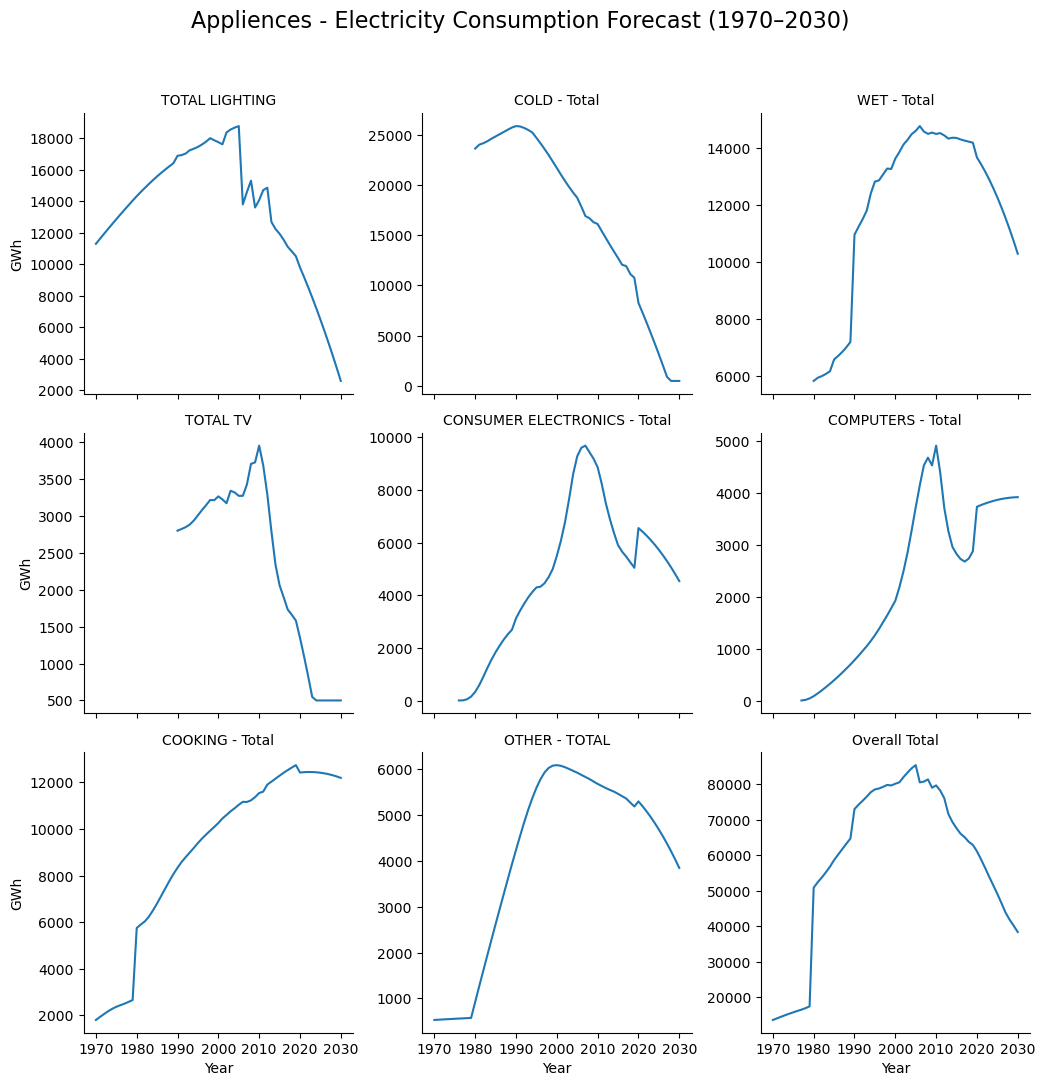

In [14]:
if melted.empty:
    print("No valid data to plot after merging historical and forecast values.")
else:
    matrix = sns.FacetGrid(melted, col="Category", col_wrap=3, height=3.5, sharey=False)
    matrix.map_dataframe(sns.lineplot, x="Year", y="Consumption (GWh)")
    matrix.set_titles("{col_name}")
    matrix.set_axis_labels("Year", "GWh")
    matrix.fig.suptitle("Appliences - Electricity Consumption Forecast (1970–2030)", fontsize=16, y=1.03)
    plt.tight_layout()
    for ax in matrix.axes.flat:
        ax.set_xticks(range(1970, 2031, 10))
    plt.show()

In [15]:
full_filtered_appliences_data.to_csv("Appliences Electricity Consumption Forcast.csv", index=False)